In [2]:
library(Seurat)
library(tidyverse)
library(ggplot2)
library(ggsci)
library(ggpubr)
library(pheatmap)
library(RColorBrewer)
library(patchwork)
library(lsa)
library(viridis)
library(hrbrthemes)
library(circlize)
library(chorddiag)
library(ggplotify)
library(data.table)
library(parmigene)
library(readxl)
library(infotheo)
library(igraph)
library(muxViz)
library(rgl)

In [2]:
objs <- readRDS("D:\\project\\PlantPhoneDB\\datasets\\GSE121619.rds")

In [3]:
objs@meta.data$geo_accession <- ifelse(objs@meta.data$orig.ident=="Control1","GSM4466787",ifelse(objs@meta.data$orig.ident=="Control2",'GSM4466788','GSM4466789'))

In [4]:
objs@meta.data$treatment[objs@meta.data$treatment %in% c("Control1","Control2")] <- "Control"

In [5]:
mycolor <- c("pink","purple","lightblue","#6495ED","lightgreen","tan1","darkred","salmon","#6B8E23")

# Figure 5A

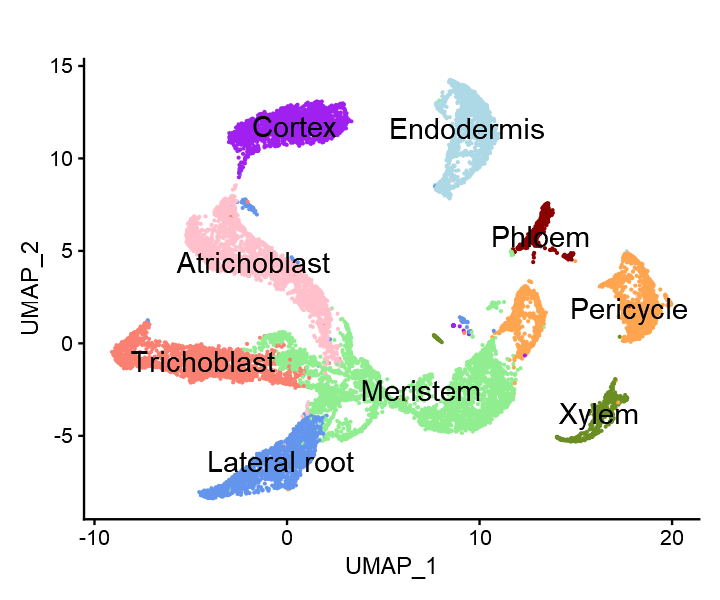

In [6]:
options(repr.plot.width=6, repr.plot.height=5)
pic1 <- DimPlot(objs,group.by = 'labels', label=TRUE, label.size = 6, reduction='umap',
               cols=mycolor)+
    NoLegend()+ggtitle("")
pic1

In [ ]:
#pdf('Figure5/Figure5A.pdf',width=6,height=5)
#pic1
#dev.off()

# Figure S5A

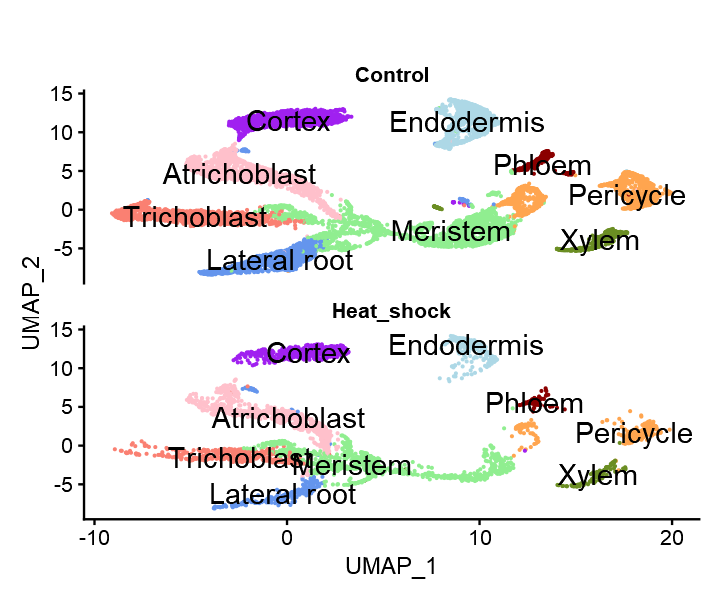

In [8]:
options(repr.plot.width=6, repr.plot.height=5)
pics1 <- DimPlot(objs,group.by = 'labels', split.by= 'treatment', label=TRUE, label.size = 6,
       cols=mycolor,ncol =1)+
    NoLegend()+ggtitle("")
pics1

In [ ]:
#pdf('Figure5/FigureS5A.pdf',width=8,height=5)
#pics1
#dev.off()

# Figure S5B

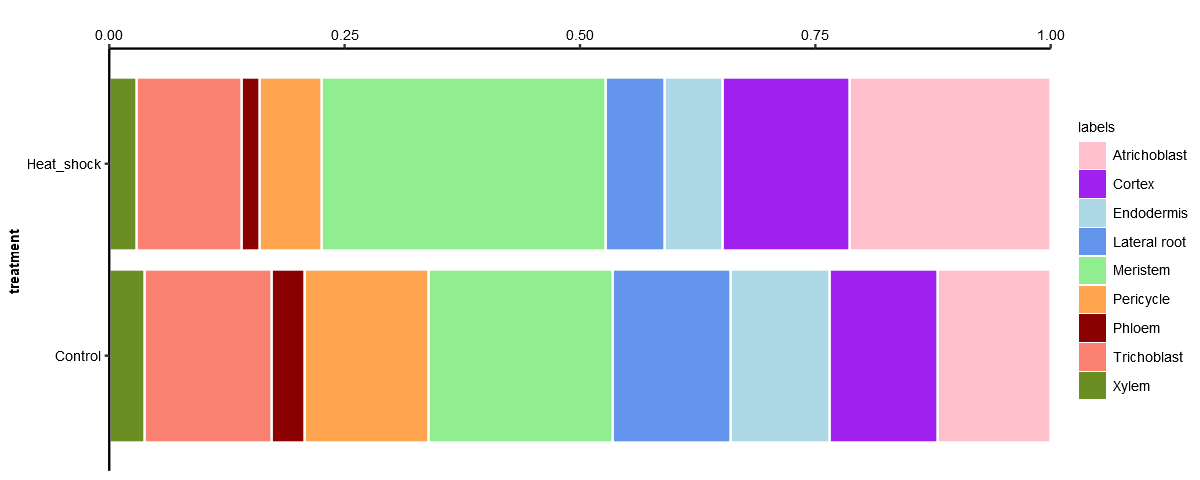

In [9]:
options(repr.plot.width=10, repr.plot.height=4)
pics2 <- objs@meta.data %>%
    ggplot(aes(treatment,fill=labels,color=I('white')))+
        geom_bar(position = "fill")+
        coord_flip()+
        theme_bw()+
        ylab("")+
        theme(panel.grid.major = element_blank(),
              panel.grid.minor = element_blank(),
              panel.border=element_blank(),
              axis.title=element_text(size=7.82,face="bold"),
              axis.text=element_text(size=7.82,color='black'),
              legend.text=element_text(size=7.82),
              plot.title = element_text(size = 7.82, face = "bold"),
              axis.line=element_line(color='black'),
              legend.title = element_text(size = 7.82))+
        scale_y_continuous(position = "right",expand = c(0,0))+
        scale_fill_manual(values=mycolor)
pics2

In [ ]:
#pdf('Figure5/FigureS5B.pdf',width=8,height=5)
#pics2
#dev.off()

In [10]:
tbl <- table(objs@meta.data$labels,objs@meta.data$treatment)

In [11]:
res = chisq.test(tbl)

In [12]:
expected = res$expected
roe = tbl/expected

In [13]:
tbl

              
               Control Heat_shock
  Atrichoblast    1427        828
  Cortex          1356        522
  Endodermis      1249        238
  Lateral root    1489        245
  Meristem        2317       1166
  Pericycle       1562        256
  Phloem           411         76
  Trichoblast     1603        430
  Xylem            441        113

# Figure 5C

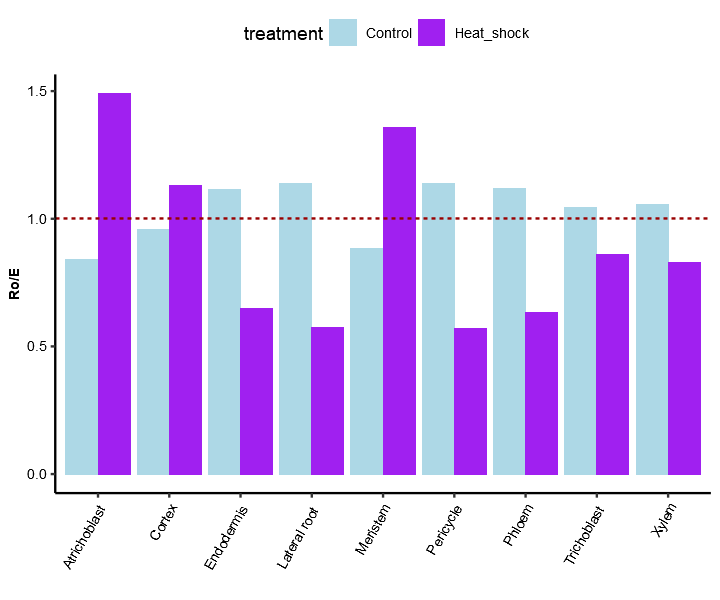

In [14]:
options(repr.plot.width=6, repr.plot.height=5)
pic2 <- roe %>%
    as.data.frame() %>%
    select(Cell=Var1, treatment= Var2, roe=Freq) %>%
    ggplot(aes(Cell,roe,fill=treatment))+
        geom_bar(stat='identity',position='dodge')+
    ylab('Ro/E')+xlab('')+
    theme_classic()+
                theme(axis.title=element_text(size=7.82,face="bold"),
                     axis.text=element_text(size=7.82,color='black'),
                     axis.text.x=element_text(angle=60,hjust=1),
                     legend.text=element_text(size=7.82),
                     plot.title = element_text(size = 7.82, face = "bold",color='black'),
                     legend.position="top")+
            geom_hline(aes(yintercept=1), colour="#990000",linetype="dashed")+
            scale_fill_manual(values=c("lightblue", "purple"))
pic2

In [16]:
DEG <- FindAllMarkers(objs,
                        logfc.threshold=0.25,
                        min.diff.pct = 0.25,
                        max.cells.per.ident = 10000,
                        only.pos=T)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17

Calculating cluster 18



In [18]:
signature <- readxl::read_excel('../mark genes/ath_doi_202104.xlsx')
sig_gene <- signature %>%
    as.data.frame() %>%
    filter(Tissue=='Root') %>%
    mutate(V1=`Cell Type`,V2=Cell_Marker) %>%
    unique(.) %>%
    select(V1,V2)

In [19]:
meta <- objs@meta.data %>%
            select(seurat_clusters,labels) %>%
            unique()

In [20]:
mark_gene <- DEG %>%
    mutate(avg_logFC=avg_log2FC) %>%
    filter(p_val_adj<0.05 & avg_log2FC>1.5 & gene %in% sig_gene$V2) %>%
    inner_join(meta,c("cluster" = "seurat_clusters")) %>%
    arrange(p_val)

In [21]:
Idents(objs) <- objs$labels

In [22]:
expr <- AverageExpression(objs,assays ='SCT')
expr <- expr$SCT
expr <- expr[mark_gene$gene,]

In [23]:
expr <- expr[,c('Trichoblast','Lateral root','Cortex','Atrichoblast','Endodermis','Xylem','Meristem','Phloem','Pericycle')]

# Figure5B

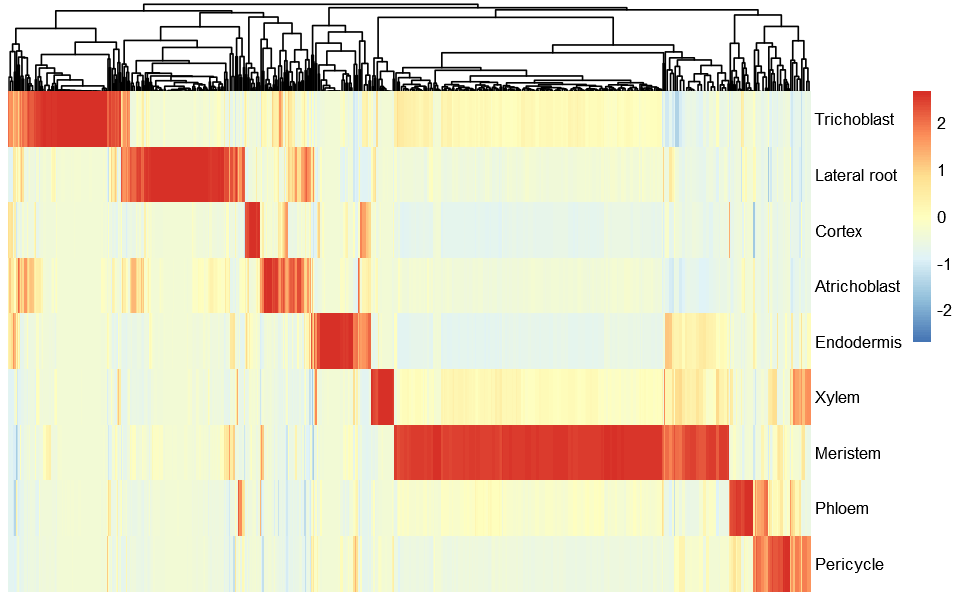

In [24]:
options(repr.plot.width=8, repr.plot.height=5)
pic3 <- pheatmap(t(expr), scale="column",angle_col=90,
         cluster_rows = F,cluster_cols = T,show_colnames=F)

In [25]:
source("../PlantPhoneDB/LRscore.r")
source("../PlantPhoneDB/heatmap_count.r")
source("../PlantPhoneDB/CCI_circle.r")
source("../PlantPhoneDB/LR_pathway.r")

In [26]:
load("../LR_pair_ath.RDa")
LR_pair <- LR_pair %>%
    filter(source!="orthologs") %>%
    select(Ligands, Receptors) %>%
    unique()

In [27]:
objs_heat <- subset(objs, treatment!="Control")

In [31]:
Heat <- LRscore(objs_heat@assays$SCT@data, LRdb=LR_pair, cluster = Idents(objs_heat), min.pct = 0.1,iterations=100, method='Average')

In [32]:
DE_test <- NULL
for(i in unique(objs$labels)){
    objs_flt <- subset(objs,labels==i)
    Idents(objs_flt) <- objs_flt$treatment
    degs <- FindAllMarkers(objs_flt,
                        logfc.threshold=0.25,
                        min.diff.pct = 0.25,
                        max.cells.per.ident = 10000)
    degs <- degs %>%
        mutate(avg_logFC=avg_log2FC, labels=i) %>%
        filter(p_val_adj<0.05) %>%
                mutate(label_gene=paste0(labels,"_",gene))
    DE_test <- rbind(DE_test,degs)
}

Calculating cluster Control

Calculating cluster Heat_shock

Calculating cluster Control

Calculating cluster Heat_shock

Calculating cluster Control

Calculating cluster Heat_shock

Calculating cluster Control

Calculating cluster Heat_shock

Calculating cluster Control

Calculating cluster Heat_shock

Calculating cluster Control

Calculating cluster Heat_shock

Calculating cluster Control

Calculating cluster Heat_shock

Calculating cluster Control

Calculating cluster Heat_shock

Calculating cluster Control

Calculating cluster Heat_shock



In [33]:
Heat_sig <- Heat %>%
    filter(Pvalue<0.05) %>%
    mutate(Ligands_cell_gene=paste0(Ligands_cell,"_",Ligands), Receptors_cell_gene=paste0(Receptors_cell,"_",Receptors)) %>%
    filter(Ligands_cell_gene %in% DE_test$label_gene | Receptors_cell_gene %in% DE_test$label_gene)  %>%
    select(-Ligands_cell_gene,-Receptors_cell_gene)

In [ ]:
#write.csv(Heat_sig,"../Table S8.csv",row.names=F)

In [2]:
Heat_sig <- read.csv("../Table S8.csv",skip=1,header=T)

In [34]:
interaction_count <- Heat_sig%>%
    group_by(Ligands_cell,Receptors_cell) %>%
    summarise(Number=n(),.groups = 'drop')

In [35]:
sum(interaction_count$Number)

[1] 1640

In [37]:
interaction_count %>%
    mutate(Type=ifelse(Ligands_cell==Receptors_cell,"Autocrine","Paracrine")) %>%
    group_by(Type) %>%
    summarise(Number=sum(Number))

Type,Number
<chr>,<int>
Autocrine,183
Paracrine,1457


In [38]:
Autocrine <- interaction_count[interaction_count$Ligands_cell==interaction_count$Receptors_cell,]

In [39]:
Paracrine <- interaction_count[interaction_count$Ligands_cell!=interaction_count$Receptors_cell,]

# Figure5SC Figure5SD 

In [41]:
pics3 <- as.grob(~CCI_circle(Paracrine, mycolor))
pics4 <- as.grob(~CCI_circle(Autocrine, mycolor))

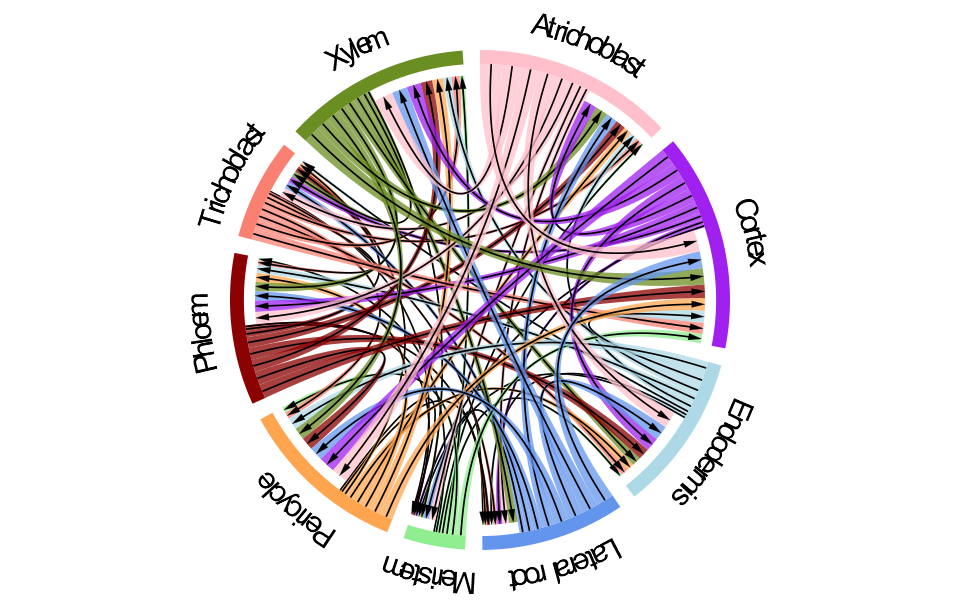

In [44]:
CCI_circle(Paracrine, mycolor)

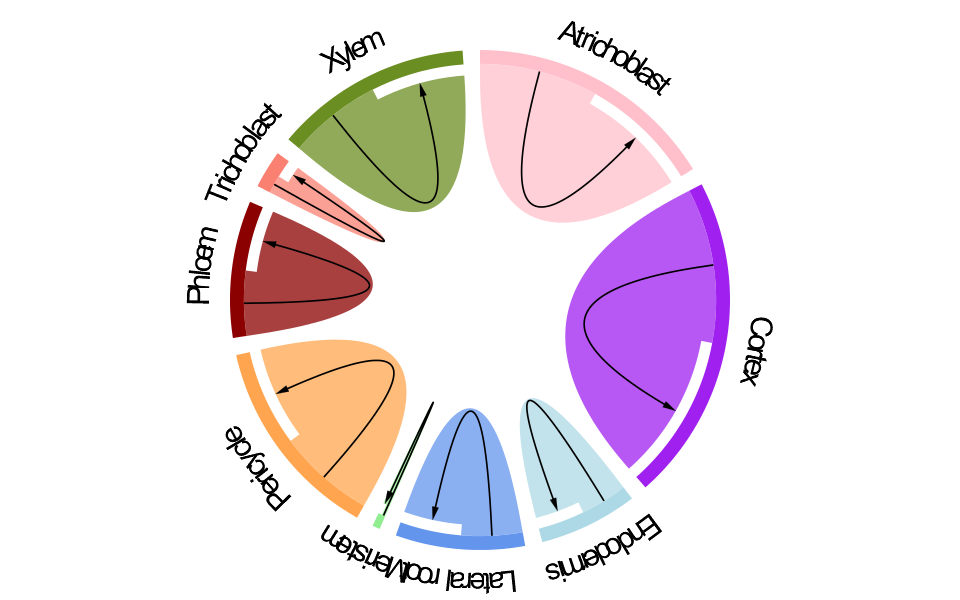

In [45]:
CCI_circle(Autocrine, mycolor)

In [ ]:
#pdf('Figure5/FigureS5C.pdf',width=8,height=5)
#CCI_circle(Paracrine, mycolor)
#dev.off()

In [ ]:
#pdf('Figure5/FigureS5D.pdf',width=8,height=5)
#CCI_circle(Autocrine, mycolor)
#dev.off()

# Figure5SE

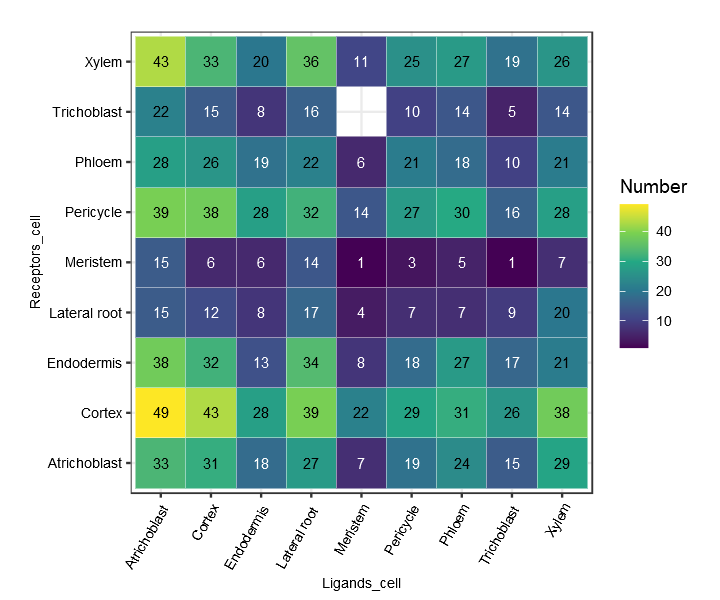

In [52]:
options(repr.plot.width=6, repr.plot.height=5)
heatmap_count(interaction_count,text_size=7.82,number_size=3,decimal=4,title="")

In [53]:
head(interaction_count)

Ligands_cell,Receptors_cell,Number
<chr>,<chr>,<int>
Atrichoblast,Atrichoblast,33
Atrichoblast,Cortex,49
Atrichoblast,Endodermis,38
Atrichoblast,Lateral root,15
Atrichoblast,Meristem,15
Atrichoblast,Pericycle,39


In [ ]:
#pdf('Figure5/FigureS5E.pdf',width=8,height=5)
#heatmap_count(interaction_count,text_size=15,number_size=5,decimal=4)
#dev.off()

In [ ]:
#options(repr.plot.width=14, repr.plot.height=7)
#pics1/pics2+plot_layout(height=c(5,1))|(plot_spacer()/pics3/pics4+plot_layout(height=c(0,1,1)))|plot_spacer()/pics4

In [ ]:
#options(repr.plot.width=14, repr.plot.height=7)
#pdf("Figure5/FigureS5.pdf",width=14,height=7)
#pics1/pics2+plot_layout(height=c(6,1))|(plot_spacer()/pics3/pics4+plot_layout(height=c(0,1,1)))|plot_spacer()/pics4
#dev.off()

In [55]:
Top10 <- Heat_sig %>%
    arrange(desc(Score)) %>%
    select(LR_pair) %>%
    unique() %>%
    head(10) %>%
    inner_join(Heat) %>%
    select(LR_pair,Cell_pair,Score) %>%
    spread(.,Cell_pair,Score) %>%
    replace(is.na(.), 0)

Joining, by = "LR_pair"



In [56]:
rownames(Top10) <- Top10$LR_pair
Top10 <- Top10[,-1]
Top10 <- t(Top10)

In [57]:
Top10 <- apply(Top10,2,function(x){x/max(x)})

# Figure5E

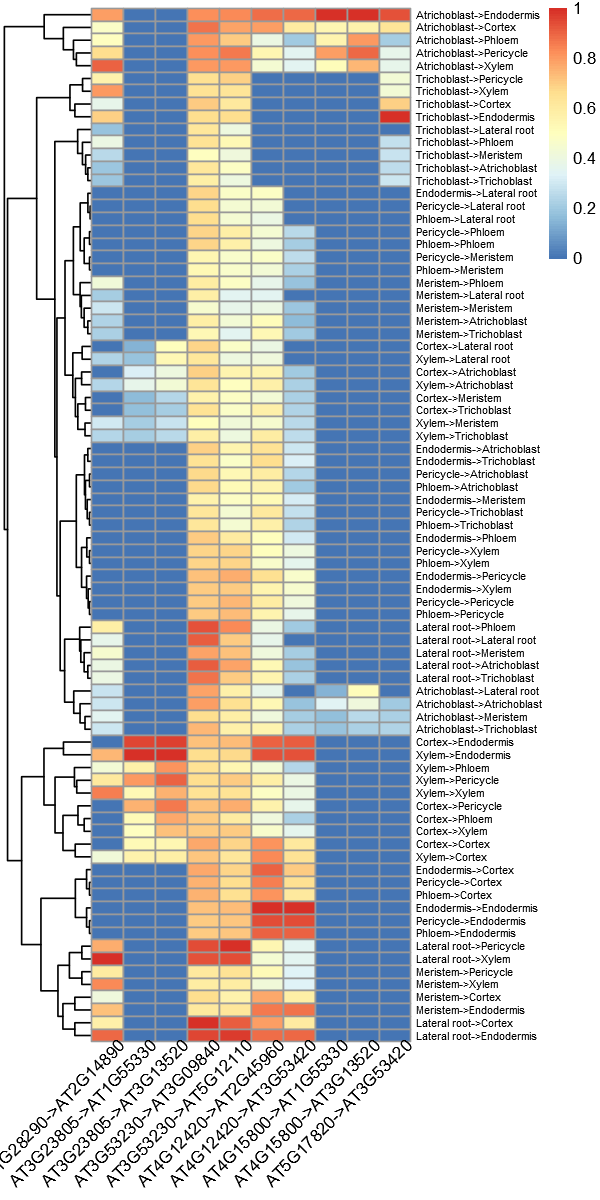

In [58]:
options(repr.plot.width=5, repr.plot.height=10)
pic6 <- pheatmap(Top10, scale="none",angle_col=45,fontsize_row=6,
         cluster_rows = T,cluster_cols = F,show_colnames=T)

# Figure5D

In [ ]:
#pdf('Figure5/Figure5D.pdf')
#CCI_circle(interaction_count, mycolor)
#dev.off()

In [59]:
pic5 <- as.grob(~CCI_circle(interaction_count, mycolor))

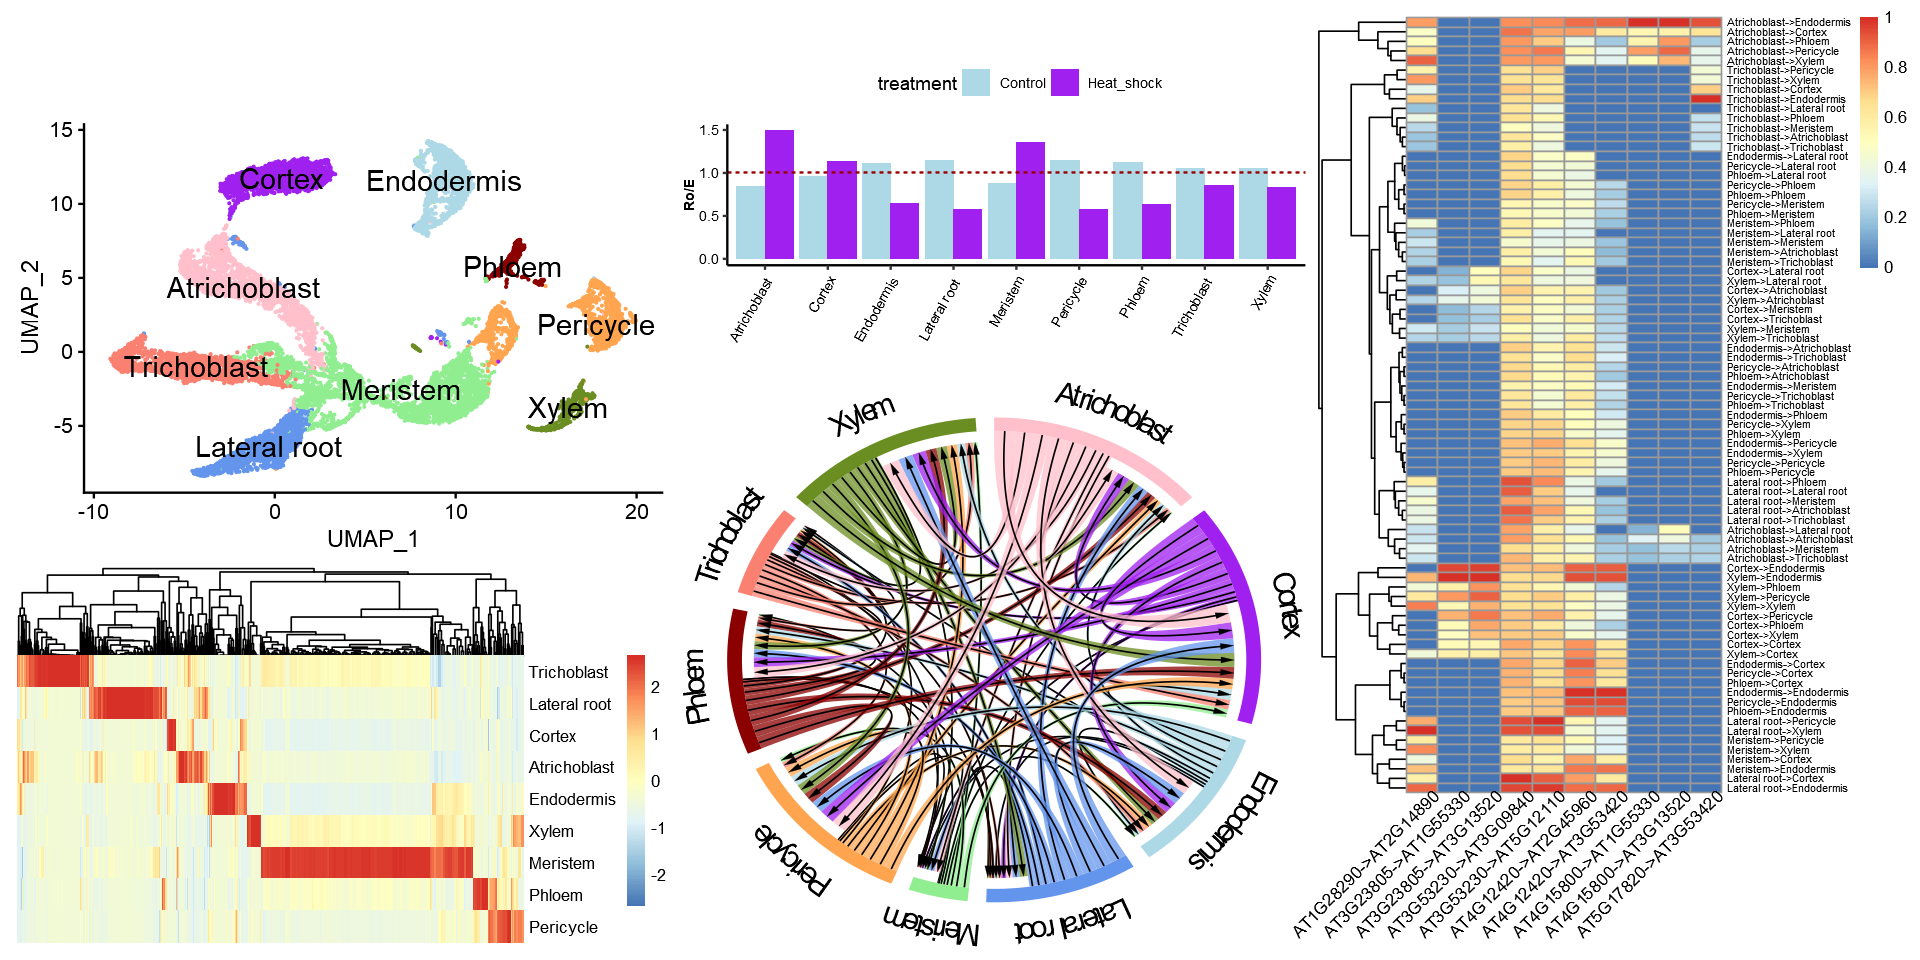

In [73]:
options(repr.plot.width=16, repr.plot.height=8)
(pic1/pic3$gtable+plot_layout(height=c(1,1))|(pic2/pic5+plot_layout(height=c(1,4))))|(pic6$gtable)

# Figure5

In [ ]:
#pdf("Figure5/Figure5.pdf",width=14,height=7)
#(pic1/pic3$gtable+plot_layout(height=c(1,1))|(pic2/pic5+plot_layout(height=c(1,4))))|(pic6$gtable)
#dev.off()

In [61]:
geneSet <- fread('../plantGSAD/Ara_ALL.KEGG.txt')
geneSet$Gene <- toupper(geneSet$Gene)

In [66]:
table(geneSet$Category)


KEGG 
6743 

In [62]:
CellA <- "Atrichoblast"
CellB <- "Cortex"
lr <- subset(Heat_sig,Ligands_cell==CellA & Receptors_cell==CellB )

In [67]:
Heat_sig %>%
    arrange(desc(Score)) %>%
    select(LR_pair) %>%
    unique() %>%
    head(10) ->mm

In [68]:
lr_test <- subset(lr,LR_pair=="AT1G28290->AT2G14890")

In [69]:
pathway_result2 <- LR_pathway(lr, objs_heat, CellA, CellB, neighbor=2, geneSet)

In [70]:
pathway_result2$FDR <- p.adjust(pathway_result2$Pvalue,method='BH')

In [71]:
pathway_result2 <- pathway_result2[order(pathway_result2$Pvalue),]

In [74]:
dim(pathway_result2)

[1] 1726    8

# Table S9

In [ ]:
write.csv(pathway_result2,"../Table S9.csv",row.names=F)

In [90]:
pathway_result <- subset(pathway_result2,LR_pair=="AT1G28290->AT2G14890")

In [91]:
kk <- pathway_result %>%
    arrange(Pvalue) %>%
    head(1)

In [92]:
head(kk)

,LR_pair,Cell_pair,Pathway,GeneRatio,BgRatio,Pvalue,OverlapGene,FDR
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>
1,AT1G28290->AT2G14890,Atrichoblast->Cortex,KEGG_RIBOSOME,64/260,233/19638,4.370864e-67,"AT1G14320, AT1G22780, AT1G23290, AT1G26880, AT1G33120, AT1G33140, AT1G52300, AT1G56045, AT1G66580, AT1G67430, AT1G70600, AT1G77940, AT2G01250, AT2G19730, AT2G25210, AT2G32060, AT2G36620, AT2G39460, AT2G43460, AT2G47610, AT3G02080, AT3G02190, AT3G04840, AT3G05590, AT3G06700, AT3G11510, AT3G16080, AT3G18740, AT3G22230, AT3G23390, AT3G25520, AT3G28900, AT3G48930, AT3G53430, AT3G53890, AT3G55280, AT3G55750, AT3G56340, AT3G59540, AT3G60245, AT3G60770, AT3G61110, AT3G62870, AT4G00100, AT4G15000, AT4G17390, AT4G18100, AT4G31985, AT5G02960, AT5G03850, AT5G09510, AT5G16130, AT5G22440, AT5G27700, AT5G27770, AT5G27850, AT5G28060, AT5G39740, AT5G41520, AT5G47700, AT5G47930, AT5G56670, AT5G62300, AT5G64140",3.772056e-64


# Arena3D for visualization

In [93]:
needGene <- unique(unlist(str_split(kk$OverlapGene,",")))

In [94]:
LR <- data.frame(SourceNode="AT1G28290",TargetNode="AT2G14890",Weight=1,SourceLayer="Ligand",TargetLayer="Receptor")
LR_target <- data.frame(SourceNode="AT2G14890",TargetNode=needGene,Weight=1,SourceLayer="Receptor",TargetLayer="Targets")
LR <- rbind(LR,LR_target)

In [ ]:
#write.table(LR,"LR_test.txt",row.names=F,sep="\t",quote=F)